In [ ]:
from pyspark.sql import SparkSession
import os

print("Starting Spark Session...")
spark = SparkSession.builder \
    .appName("CSV to Parquet") \
    .master("local[*]") \
    .config("spark.driver.memory", "12g") \
    .getOrCreate()
print("Spark Session started.")

# Path to your streamed CSV file
csv_path = os.path.expanduser("~/bigDataPraktikum/rdf_streamed.csv")

# Read CSV into a DataFrame
print(f"[INFO] Reading CSV from {csv_path}")
df = spark.read.option("header", True).csv(csv_path)

# Coalesce to 1 partition so you get a single parquet file
output_path = os.path.expanduser("~/bigDataPraktikum/rdf_parquet_single")
df.coalesce(1).write.mode("overwrite").parquet(output_path)

print(f"[INFO] CSV converted and saved as a single Parquet file at {output_path}")

Starting Spark Session...


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/09/24 22:53:01 WARN Utils: Your hostname, Vadim-Sokow, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/09/24 22:53:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/24 22:53:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session started.
[INFO] Reading CSV from /home/arne/bigDataPraktikum/rdf_streamed.csv


[INFO] CSV converted and saved as a single Parquet file at /home/arne/bigDataPraktikum/rdf_parquet_single


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sha2, col
import json

print("Starting Spark Session...")
spark = SparkSession.builder \
    .appName("CSV to Parquet") \
    .master("local[12]") \
    .config("spark.driver.memory", "12g") \
    .getOrCreate()
print("Spark Session started.")

# Load parquet dump
df = spark.read.parquet("/home/arne/bigDataPraktikum/rdf_parquet_single/part-00000-03302921-7e72-4163-9b2a-3fc0bc157873-c000.snappy.parquet")

# --- Predicate partitioning ---
df_pred = df.withColumn("predicate_hash", sha2(col("predicate"), 256))
df_pred.write.partitionBy("predicate_hash").parquet("output/by_predicate")

# Extract mapping predicate ↔ hash
predicate_mapping = df_pred.select("predicate_hash", "predicate").distinct().collect()

# Save mapping as JSON
pred_map_dict = {row["predicate_hash"]: row["predicate"] for row in predicate_mapping}
with open("predicate_mapping.json", "w") as f:
    json.dump(pred_map_dict, f, indent=2)

Starting Spark Session...
Spark Session started.


25/09/25 13:18:06 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [95]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sha2
import json

print("Starting Spark Session...")
spark = SparkSession.builder \
    .appName("CSV to Parquet") \
    .master("local[*]") \
    .config("spark.driver.memory", "12g") \
    .getOrCreate()
print("Spark Session started.")

# Load the complete parquet dump
df = spark.read.parquet("rdf_parquet_single/part-00000-03302921-7e72-4163-9b2a-3fc0bc157873-c000.snappy.parquet")

print(f"Total triples: {df.count()}")

# Step 1: Extract type information for each subject
print("Extracting type information...")
rdf_type_df = df.filter(col("predicate") == "http://www.w3.org/1999/02/22-rdf-syntax-ns#type")
print(f"Type triples: {rdf_type_df.count()}")

# Create type mapping with hash
types_with_hash = rdf_type_df.select(
    col("subject"),
    col("object").alias("type"),
    sha2(col("object"), 256).alias("type_hash")
).distinct()

print(f"Unique subject-type pairs: {types_with_hash.count()}")

# Step 2: Join ALL triples with their type information
print("Joining all triples with type information...")
df_with_types = df.join(
    types_with_hash.select("subject", "type_hash"), 
    on="subject", 
    how="inner"  # Only keep subjects that have a type
)

print(f"Triples with type information: {df_with_types.count()}")

# Step 3: Handle subjects with multiple types (if any)
# Check if there are subjects with multiple types
multi_type_subjects = types_with_hash.groupBy("subject").count().filter(col("count") > 1)
multi_type_count = multi_type_subjects.count()

if multi_type_count > 0:
    print(f"Warning: {multi_type_count} subjects have multiple types.")
    print("This will create duplicate triples in different type partitions.")
    
    # If you want to handle this differently, you could:
    # 1. Pick the "primary" type (e.g., first alphabetically)
    # 2. Create a separate partition for multi-type entities
    # 3. Accept the duplication (current approach)

# Step 4: Write partitioned data
print("Writing partitioned data...")
df_with_types.write \
    .mode("overwrite") \
    .partitionBy("type_hash") \
    .parquet("output/by_type")

print("Partitioned parquet written successfully.")

# Step 5: Save type mapping
print("Creating type mapping...")
type_mapping = types_with_hash.select("type_hash", "type").distinct().collect()
type_map_dict = {row["type"]: row["type_hash"] for row in type_mapping}

with open("reverse_type_mapping.json", "w") as f:
    json.dump(type_map_dict, f, indent=2)

print(f"Type mapping saved with {len(type_map_dict)} unique types.")

Starting Spark Session...
Spark Session started.
Total triples: 237451247
Extracting type information...


25/09/25 16:35:20 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Type triples: 51687598


Unique subject-type pairs: 51235252
Joining all triples with type information...


Triples with type information: 1773865487


This will create duplicate triples in different type partitions.
Writing partitioned data...


Partitioned parquet written successfully.
Creating type mapping...


Type mapping saved with 779 unique types.


In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sha2
import json

print("Starting Spark Session...")
spark = SparkSession.builder \
    .appName("CSV to Parquet") \
    .master("local[*]") \
    .config("spark.driver.memory", "24g") \
    .config("spark.sql.shuffle.partitions", "2000") \
    .getOrCreate()
print("Spark Session started.")

# Load parquet dump that's already partitioned by type
df_type = spark.read.parquet("output/by_type")

print("Columns in df_type:", df_type.columns)
print("Number of partitions before:", df_type.rdd.getNumPartitions())

# Add predicate hash
df_tp = df_type.withColumn("predicate_hash", sha2(col("predicate"), 256))

print("Columns after adding predicate_hash:", df_tp.columns)

# Optional: Check distribution to ensure you're not creating too many small partitions
print("Checking predicate distribution...")
predicate_counts = df_tp.groupBy("predicate_hash").count().collect()
print(f"Number of unique predicates: {len(predicate_counts)}")

# Repartition for better shuffle performance
# You might want to experiment with the number of partitions
df_tp = df_tp.repartition(col("type_hash"), col("predicate_hash"))

print("Number of partitions after repartition:", df_tp.rdd.getNumPartitions())

# Write with hierarchical partitioning: type_hash/predicate_hash/
df_tp.write \
    .mode("overwrite") \
    .partitionBy("type_hash", "predicate_hash") \
    .parquet("output/by_type_predicate")

print("Partitioned parquet written successfully.")

Starting Spark Session...
Spark Session started.


25/09/25 11:52:44 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Columns in df_type: ['subject', 'predicate', 'object', 'type_hash']
Number of partitions before: 3585
Columns after adding predicate_hash: ['subject', 'predicate', 'object', 'type_hash', 'predicate_hash']
Checking predicate distribution...


Number of unique predicates: 89394


Number of partitions after repartition: 1043


Partitioned parquet written successfully.


In [20]:
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sha2, lit, expr, regexp_extract
from pyspark.sql import DataFrame
import json
from pyspark.sql.types import StringType
from pyspark.sql import functions as F
import hashlib
import copy

print("Starting Spark Session...")
spark = SparkSession.builder \
    .appName("CSV to Parquet") \
    .master("local[*]") \
    .config("spark.driver.memory", "24g") \
    .config("spark.sql.shuffle.partitions", "2000") \
    .getOrCreate()
print("Spark Session started.")

with open("reverse_type_mapping.json", "r") as f:
    type_map = json.load(f)

with open("reverse_predicate_mapping.json", "r") as f:
    predicate_map = json.load(f)

wgs = "http://www.w3.org/2003/01/geo/wgs84_pos#"
dbp = "http://dbpedia.org/property/"
dbr = "http://dbpedia.org/resource/"
dbo = "http://dbpedia.org/ontology/"
rdf = "http://www.w3.org/1999/02/22-rdf-syntax-ns#"
rdfs = "http://www.w3.org/2000/01/rdf-schema#"


def loadData(partition: str, partitionToLoad: list[tuple[str, str]] | dict) -> DataFrame:
    if partition == "predicate":
        filePaths = [f"output/by_{partition}/predicate_hash={predicate_map[uri + name]}/*.parquet" for uri, name in partitionToLoad]
        df = spark.read.parquet(*filePaths)
        return df
    elif partition == "type":
        filePaths = [f"output/by_{partition}/type_hash={type_map[uri + name]}/*.parquet" for uri, name in partitionToLoad]
        df = spark.read.parquet(*filePaths)
        return df
    elif partition == "type_predicate":
        # partitionToLoad is a list of dicts, each with a single key (type URI) and value (list of (uri, name) tuples)
        filePaths = []
        for type_uri, predicates in partitionToLoad.items():
            type_hash = type_map[type_uri]
            for uri, name in predicates:
                predicate_hash = predicate_map[uri + name]
                filePaths.append(f"output/by_type_predicate/type_hash={type_hash}/predicate_hash={predicate_hash}/*.parquet")
        df = spark.read.parquet(*filePaths)
        return df
    elif partition == "all":
        df = spark.read.parquet("/home/arne/bigDataPraktikum/rdf_parquet_single/part-00000-03302921-7e72-4163-9b2a-3fc0bc157873-c000.snappy.parquet")
        return df


def queryAnyCountryInSquare(df: DataFrame, minLat: float = 40.0, maxLat: float = 60.0, minLong: float = -10.0, maxLong: float = 30.0) -> list[str]:
    # 1. Countries only
    startTime = time.perf_counter_ns()
    country_df = df.filter(
        (col("predicate") == "http://www.w3.org/1999/02/22-rdf-syntax-ns#type") &
        (col("object") == "http://dbpedia.org/ontology/Country")
    ).select(col("subject").alias("state"))

    # 2. Latitude
    lat_df = df.filter(
        col("predicate") == "http://www.w3.org/2003/01/geo/wgs84_pos#lat"
    ).withColumn(
        "lat_str", regexp_extract("object", '^"(-?[0-9]+\\.?[0-9]*)', 1)
    ).withColumn(
        "lat", expr("try_cast(lat_str as double)")
    ).filter(col("lat").isNotNull()) \
    .select(col("subject").alias("state"), "lat")

    # 3. Longitude
    long_df = df.filter(
        col("predicate") == "http://www.w3.org/2003/01/geo/wgs84_pos#long"
    ).withColumn(
        "long_str", regexp_extract("object", '^"(-?[0-9]+\\.?[0-9]*)', 1)
    ).withColumn(
        "long", expr("try_cast(long_str as double)")
    ).filter(col("long").isNotNull()) \
    .select(col("subject").alias("state"), "long")

    # 4. Labels (English only)
    labels_df = df.filter(
        col("predicate") == "http://www.w3.org/2000/01/rdf-schema#label"
    ).withColumn(
        "label", regexp_extract("object", '^"(.*)"@..$', 1)
    ).withColumn(
        "lang", regexp_extract("object", '^".*"@(..)$', 1)
    ).filter(col("lang") == "en") \
    .select(col("subject").alias("state"), "label")

    # Deduplicate labels: one label per country
    labels_dedup = labels_df.groupBy("state").agg(F.first("label").alias("label"))

    # Aggregate coordinates per country (average here, but you could use first)
    coords_df = lat_df.join(long_df, "state") \
                    .groupBy("state") \
                    .agg(
                        F.first("lat").alias("lat"),
                        F.first("long").alias("long")
                    )

    # 5. Join all together and apply bounding box filter
    result_df = country_df.join(labels_dedup, "state") \
                      .join(coords_df, "state") \
                      .filter((col("lat") >= minLat) & (col("lat") <= maxLat)) \
                      .filter((col("long") >= minLong) & (col("long") <= maxLong)) \
                      .select("label").limit(10)

    result = result_df.collect()
    endTime = time.perf_counter_ns()
    elapsedTime = endTime - startTime
    print(f"Query executed in {elapsedTime} ns")
    result = [row.label for row in result]
    return result, elapsedTime / 1_000_000, df.count()


def queryTenLargestCities(df: DataFrame) -> list[tuple[int, str]]:
    startTime = time.perf_counter_ns()
    # 1. Population triples
    pop_df = df.filter(
            col("predicate") == "http://dbpedia.org/ontology/populationTotal"
        ).withColumn(
            "pop_str", regexp_extract("object", '^"([0-9]+)"', 1)  # extract digits inside quotes
        ).withColumn(
            "popTotal", col("pop_str").cast("long")
        ).select(
            col("subject").alias("state"),
            "popTotal"
        )

    # 2. Type = dbo:Place
    place_df = df.filter(
        (col("predicate") == rdf + "type") &
        (col("object") == dbo + "City")
    ).select(col("subject").alias("state"))

    # 3. Labels with language tag
    # "..."@en style, extract value and language
    labels_df = df.filter(
        col("predicate") == rdfs + "label"
    ).withColumn(
        "label", F.regexp_extract("object", '^"(.*)"@..$', 1)
    ).withColumn(
        "lang", F.regexp_extract("object", '^".*"@(..)$', 1)
    ).filter(
        col("lang") == "en"
    ).select(
        col("subject").alias("state"),
        "label"
    )

    # 4. Join everything
    result_df = pop_df.join(place_df, "state") \
                    .join(labels_df, "state") \
                    .select("popTotal", "label") \
                    .orderBy(F.desc("popTotal")) \
                    .limit(10)

    result = result_df.collect()
    endTime = time.perf_counter_ns()
    elapsedTime = endTime - startTime
    print(f"Query executed in {elapsedTime} ns")
    result = [row.label for row in result]
    return result, elapsedTime / 1_000_000, df.count()


def queryLeaderOfGermany(df: DataFrame) -> list[tuple[str, str]]:
    startTime = time.perf_counter_ns()
    # 1. Filter for the state "Germany"
    germany_df = df.filter(
        (col("predicate") == rdfs + "label") &
        (col("object") == '"Germany"@en')
    ).select(col("subject").alias("state"))

    # germany_df.show(100, truncate=False)

    # 2. Filter for type dbo:Place
    type_df = df.filter(
        col("predicate") == rdf + "type"
    ).filter(col("object") == dbo + "Place") \
    .select(col("subject").alias("state"))

    # 3. Filter for leader labels
    leader_label_df = df.filter(
        col("predicate") == rdfs + "label"
    ).select(
        col("subject").alias("leader_uri"),
        col("object").alias("leaderLabel")
    )

    # leader_label_df.show(100, truncate=False)

    # 4. Filter for leader relationships
    leader_rel_df = df.filter(
        col("predicate") == dbp + "leaderName"
    ).select(
        col("subject").alias("state"),
        col("object").alias("leader_uri")
    )

    # 5. Join everything together
    result_df = germany_df.join(type_df, "state") \
                        .join(leader_rel_df, "state") \
                        .join(leader_label_df, "leader_uri") \
                        .select("state", "leaderLabel")
    
    result = result_df.collect()
    endTime = time.perf_counter_ns()
    elapsedTime = endTime - startTime
    print(f"Query executed in {elapsedTime} ns")
    result = [row.leaderLabel for row in result]
    return result, elapsedTime / 1_000_000, df.count()

validationSzenarios = [
    {
        "function": queryLeaderOfGermany,
        "function_name": "queryLeaderOfGermany",
        "partition": "all",
    },
    {
        "function": queryTenLargestCities,
        "function_name": "queryTenLargestCities",
        "partition": "all",
    },
    {
        "function": queryAnyCountryInSquare,
        "function_name": "queryAnyCountryInSquare",
        "partition": "all",
    },
    {
        "function": queryLeaderOfGermany,
        "function_name": "queryLeaderOfGermany",
        "partition": "predicate",
        "data": [
            (dbo, "person"),
            (dbo, "place"),
            (dbp, "leaderName"),
            (rdf, "type"),
            (rdfs, "label")
        ]
    },
    {
        "function": queryLeaderOfGermany,
        "function_name": "queryLeaderOfGermany",
        "partition": "type",
        "data": [
            (dbo, "Place"),
            (dbo, "Person")
        ]
    },
    {
        "function": queryLeaderOfGermany,
        "function_name": "queryLeaderOfGermany",
        "partition": "type_predicate",
        "data": {
            f"{dbo}Place": [(rdf, "type"), (rdfs, "label"), (dbp, "leaderName")],
            f"{dbo}Person": [(rdf, "type"), (rdfs, "label"), (dbp, "leaderName")],
        }
    },
    {
        "function": queryTenLargestCities,
        "function_name": "queryTenLargestCities",
        "partition": "predicate",
        "data": [
            (dbo, "populationTotal"),
            (rdf, "type"),
            (rdfs, "label"),
        ]
    },
    {
        "function": queryTenLargestCities,
        "function_name": "queryTenLargestCities",
        "partition": "type",
        "data": [(dbo, "City")]
    },
    {
        "function": queryTenLargestCities,
        "function_name": "queryTenLargestCities",
        "partition": "type_predicate",
        "data": {
            f"{dbo}City": [(rdf, "type"), (rdfs, "label"), (dbo, "populationTotal")],
        }
    },
    {
        "function": queryAnyCountryInSquare,
        "function_name": "queryAnyCountryInSquare",
        "partition": "predicate",
        "data": [
            (wgs, "lat"),
            (wgs, "long"),
            (rdf, "type"),
            (rdfs, "label"),
        ]
    },
    {
        "function": queryAnyCountryInSquare,
        "function_name": "queryAnyCountryInSquare",
        "partition": "type",
        "data": [(dbo, "Country")]
    },
    {
        "function": queryAnyCountryInSquare,
        "function_name": "queryAnyCountryInSquare",
        "partition": "type_predicate",
        "data": {
            f"{dbo}Country": [(wgs, "lat"), (wgs, "long"), (rdf, "type"), (rdfs, "label")],
        }
    }
]

resultDictionary = {}
num_runs = 3  # Number of times to repeat each scenario

for scenario in validationSzenarios:
    partition = scenario["partition"]
    function_name = scenario["function_name"]
    print(f"Running {function_name} with partitioning: {partition}")
    times = []
    row_counts = []
    results = []
    for _ in range(num_runs):
        df_loaded = loadData(partition, scenario.get("data", None))
        result, duration, rowCount = scenario["function"](df_loaded)
        times.append(duration)
        row_counts.append(rowCount)
        results.append(result)
    avg_time = sum(times) / len(times)
    avg_row_count = sum(row_counts) // len(row_counts)
    # Use the result from the first run for correctness comparison
    result = results[0]
    # Initialize partition dict if not present
    if partition not in resultDictionary:
        resultDictionary[partition] = {}
    # Store benchmark for "all"
    if partition == "all":
        resultDictionary[partition][function_name] = {
            "computingTime": avg_time,
            "rowCount": avg_row_count,
            "result": result,
            "correctness": 1.0
        }
    else:
        # Find corresponding benchmark
        benchmark = resultDictionary.get("all", {}).get(function_name, {})
        benchmark_result = benchmark.get("result", [])
        # Compute correctness
        if benchmark_result:
            matching = len(set(result) & set(benchmark_result))
            correctness = matching / max(len(benchmark_result), 1)
        else:
            correctness = 0.0
        resultDictionary[partition][function_name] = {
            "computingTime": avg_time,
            "rowCount": avg_row_count,
            "correctness": correctness
        }

with open("resultDictionary.json", "w") as outfile:
    json.dump(resultDictionary, outfile, indent=2)


Starting Spark Session...
Spark Session started.
Running queryLeaderOfGermany with partitioning: all


Query executed in 13556043894 ns


Query executed in 10962997375 ns


Query executed in 9737634603 ns
Running queryTenLargestCities with partitioning: all


Query executed in 6082066621 ns


Query executed in 6696609804 ns


Query executed in 7515584554 ns
Running queryAnyCountryInSquare with partitioning: all


Query executed in 6522938206 ns


Query executed in 6266791136 ns


Query executed in 6868503773 ns
Running queryLeaderOfGermany with partitioning: predicate


Query executed in 6488180499 ns


Query executed in 6444258475 ns


Query executed in 6614287728 ns
Running queryLeaderOfGermany with partitioning: type


Query executed in 3511487581 ns


Query executed in 4082996610 ns


Query executed in 4183757174 ns
Running queryLeaderOfGermany with partitioning: type_predicate
Query executed in 946525076 ns
Query executed in 966837106 ns
Query executed in 921287185 ns
Running queryTenLargestCities with partitioning: predicate


Query executed in 2512398713 ns


Query executed in 2479939800 ns


25/09/25 18:07:17 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: output/by_type/type_hash=e56d5e39ebae6598bbf1c8d112be883104ec5db570a487aee1f7067261e8d851/*.parquet.
java.io.FileNotFoundException: File output/by_type/type_hash=e56d5e39ebae6598bbf1c8d112be883104ec5db570a487aee1f7067261e8d851/*.parquet does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.o

Query executed in 2479923580 ns
Running queryTenLargestCities with partitioning: type
Query executed in 211913976 ns


25/09/25 18:07:18 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: output/by_type/type_hash=e56d5e39ebae6598bbf1c8d112be883104ec5db570a487aee1f7067261e8d851/*.parquet.
java.io.FileNotFoundException: File output/by_type/type_hash=e56d5e39ebae6598bbf1c8d112be883104ec5db570a487aee1f7067261e8d851/*.parquet does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.o

Query executed in 210546644 ns


25/09/25 18:07:18 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: output/by_type/type_hash=e56d5e39ebae6598bbf1c8d112be883104ec5db570a487aee1f7067261e8d851/*.parquet.
java.io.FileNotFoundException: File output/by_type/type_hash=e56d5e39ebae6598bbf1c8d112be883104ec5db570a487aee1f7067261e8d851/*.parquet does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.o

Query executed in 206385123 ns
Running queryTenLargestCities with partitioning: type_predicate
Query executed in 122597665 ns
Query executed in 104681799 ns
Query executed in 104891552 ns
Running queryAnyCountryInSquare with partitioning: predicate


Query executed in 3379766752 ns


Query executed in 3395055099 ns


Query executed in 3392703327 ns
Running queryAnyCountryInSquare with partitioning: type


25/09/25 18:07:30 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: output/by_type/type_hash=9bd96af3ec2c1e5d90a178b5a06ff37b51e339e49102809154dd024c3056eb15/*.parquet.
java.io.FileNotFoundException: File output/by_type/type_hash=9bd96af3ec2c1e5d90a178b5a06ff37b51e339e49102809154dd024c3056eb15/*.parquet does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.o

Query executed in 355825430 ns


25/09/25 18:07:30 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: output/by_type/type_hash=9bd96af3ec2c1e5d90a178b5a06ff37b51e339e49102809154dd024c3056eb15/*.parquet.
java.io.FileNotFoundException: File output/by_type/type_hash=9bd96af3ec2c1e5d90a178b5a06ff37b51e339e49102809154dd024c3056eb15/*.parquet does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.o

Query executed in 298363992 ns


25/09/25 18:07:31 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: output/by_type/type_hash=9bd96af3ec2c1e5d90a178b5a06ff37b51e339e49102809154dd024c3056eb15/*.parquet.
java.io.FileNotFoundException: File output/by_type/type_hash=9bd96af3ec2c1e5d90a178b5a06ff37b51e339e49102809154dd024c3056eb15/*.parquet does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.o

Query executed in 322752397 ns
Running queryAnyCountryInSquare with partitioning: type_predicate
Query executed in 184440867 ns
Query executed in 182878394 ns
Query executed in 181169401 ns


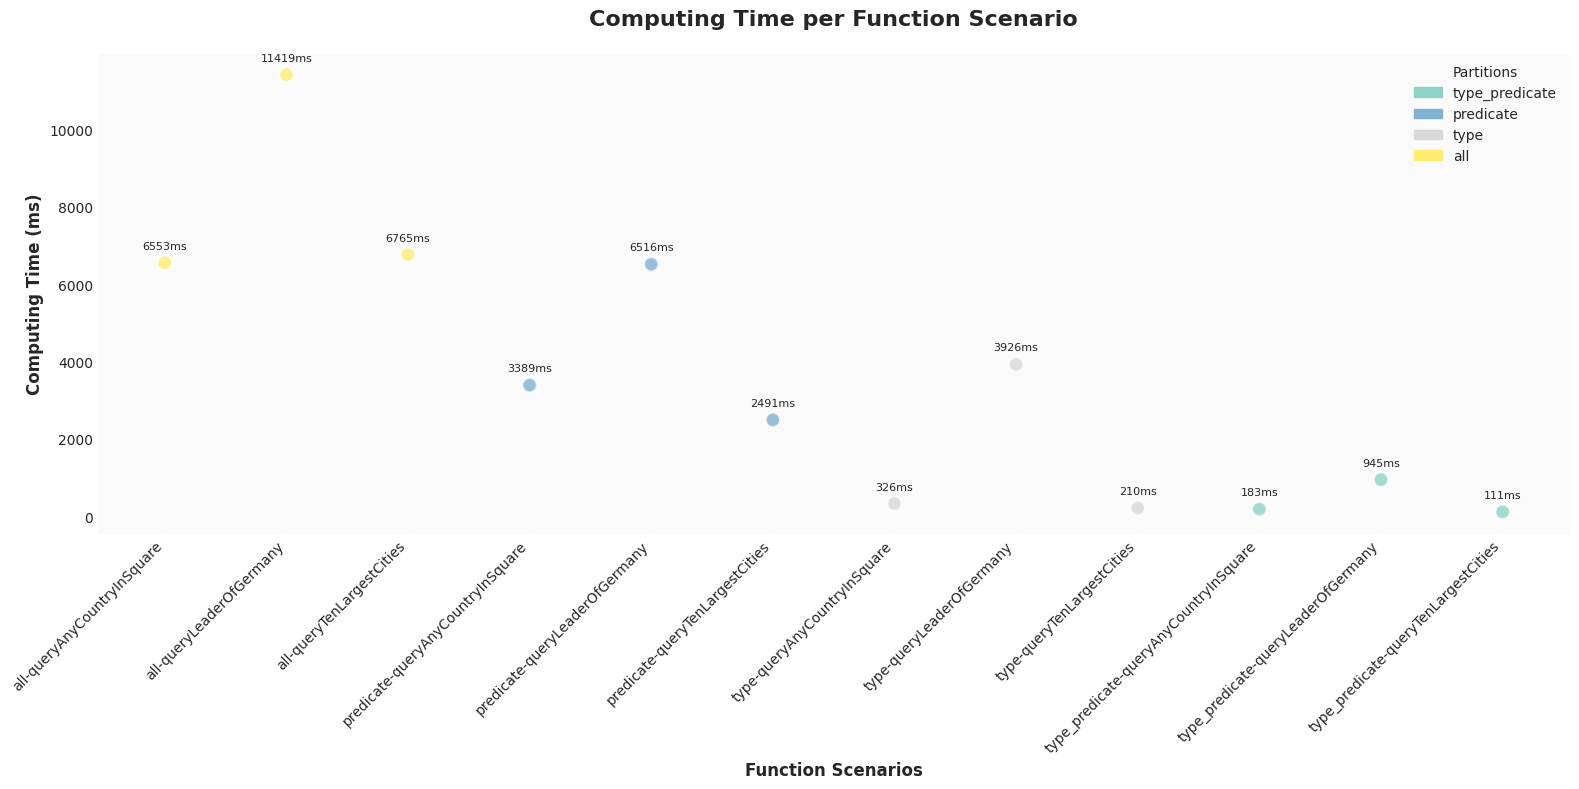

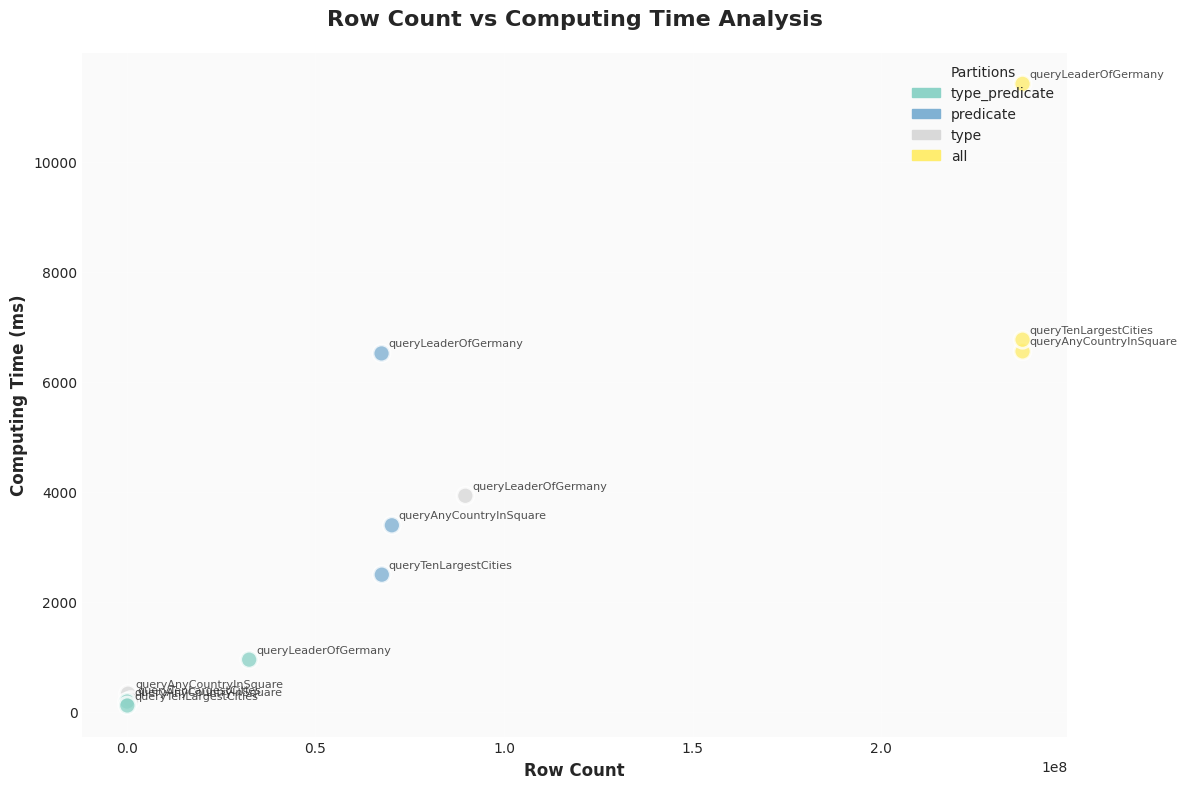

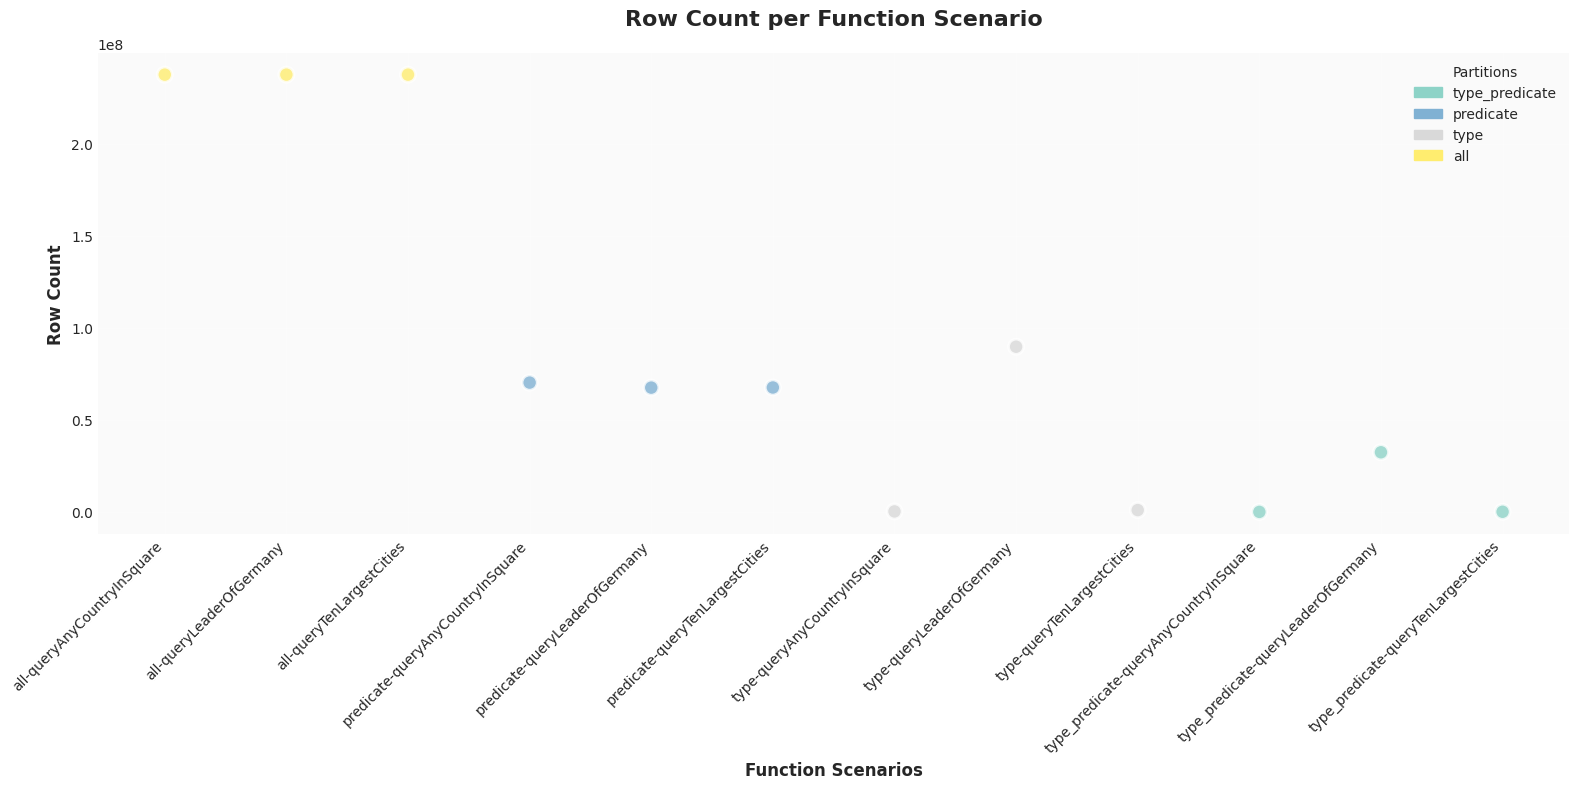

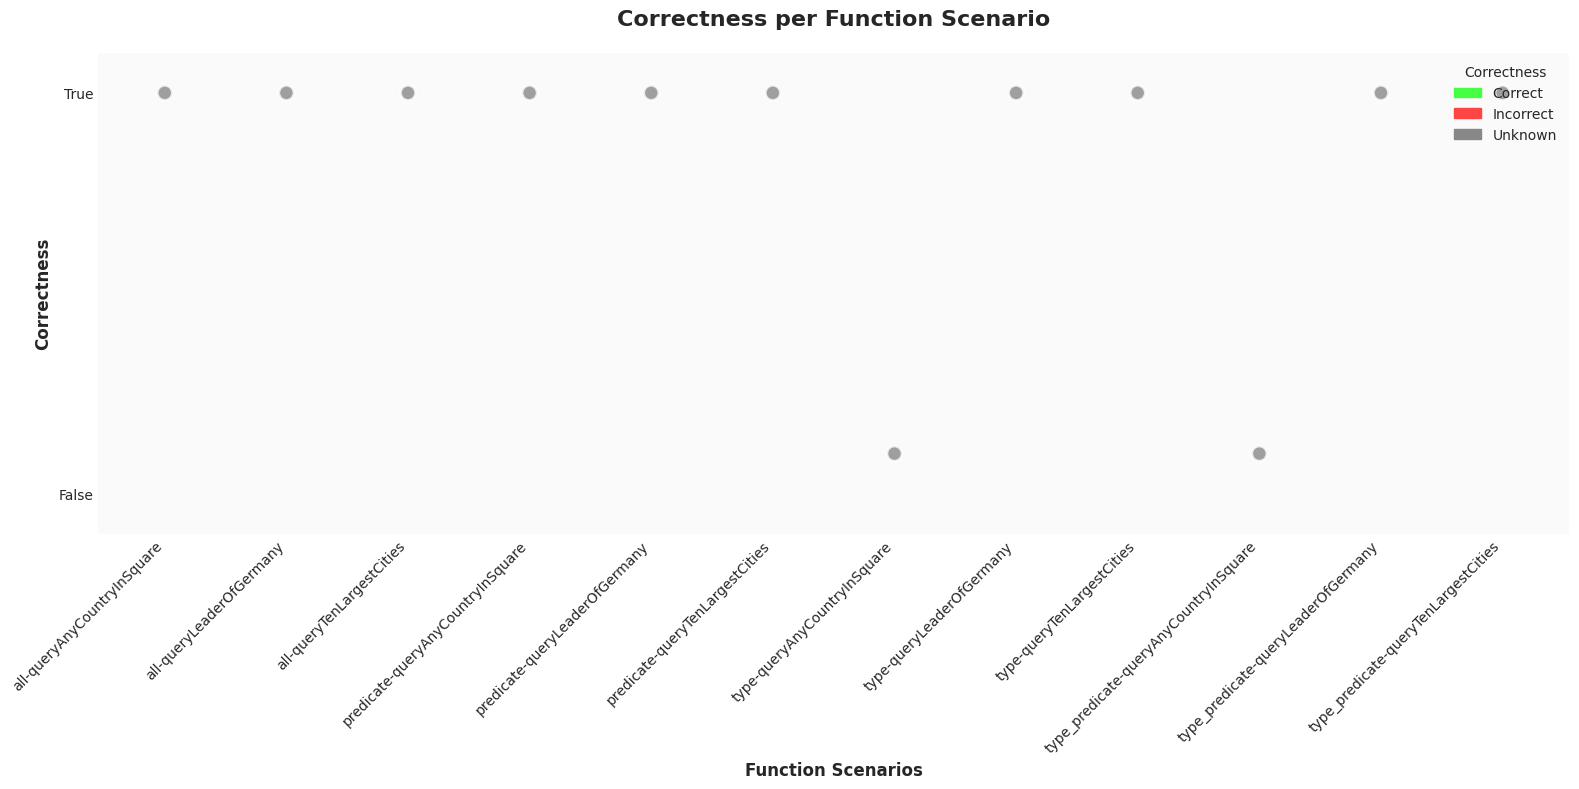

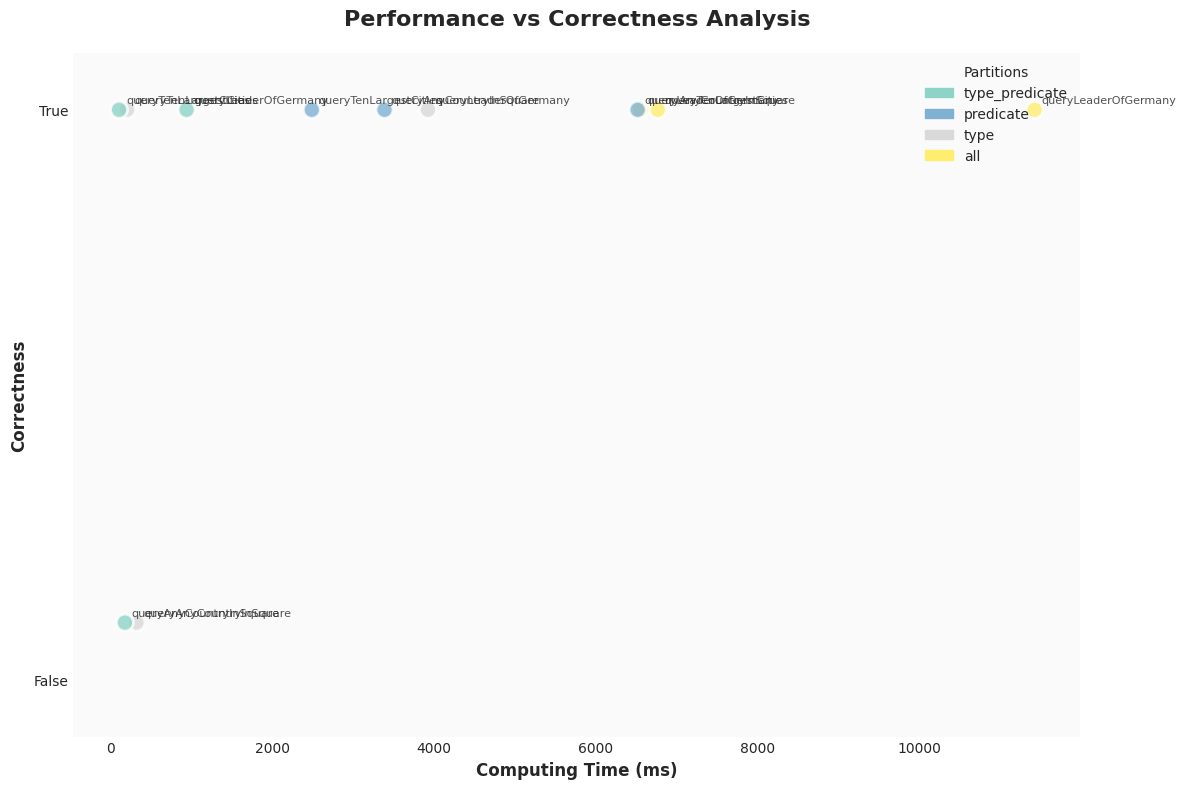

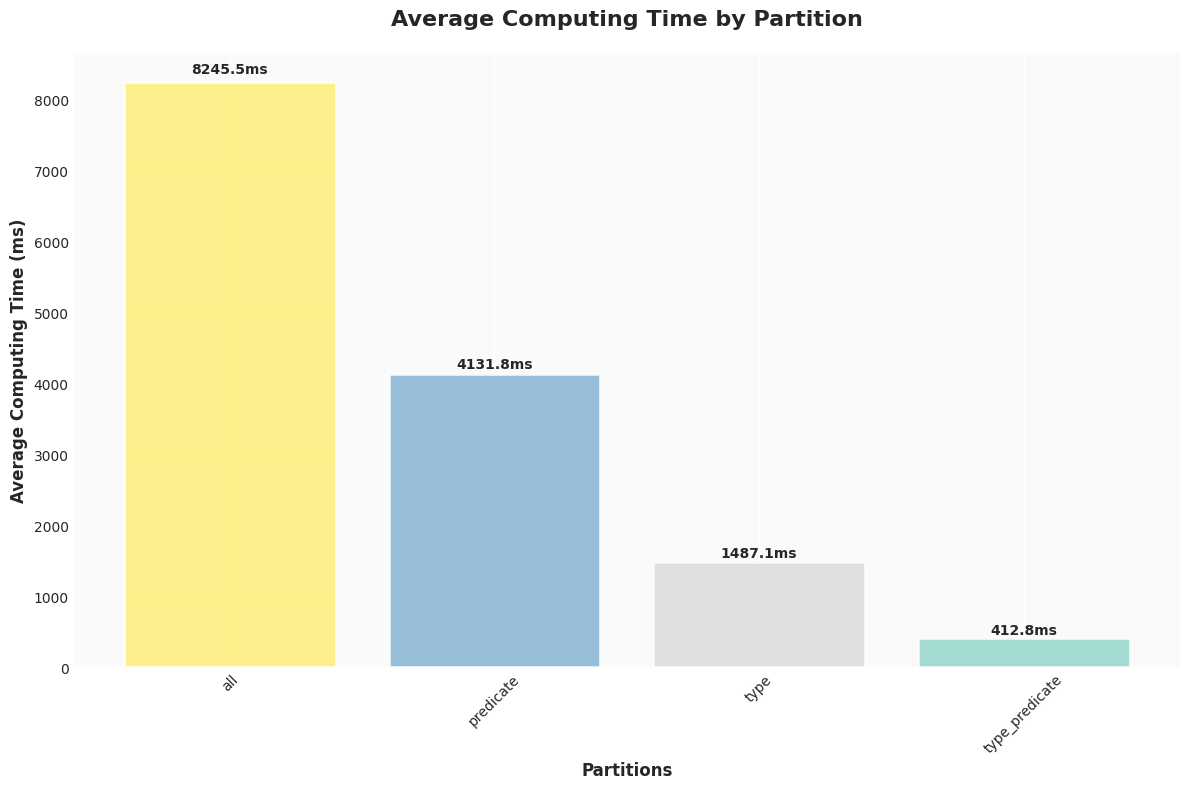

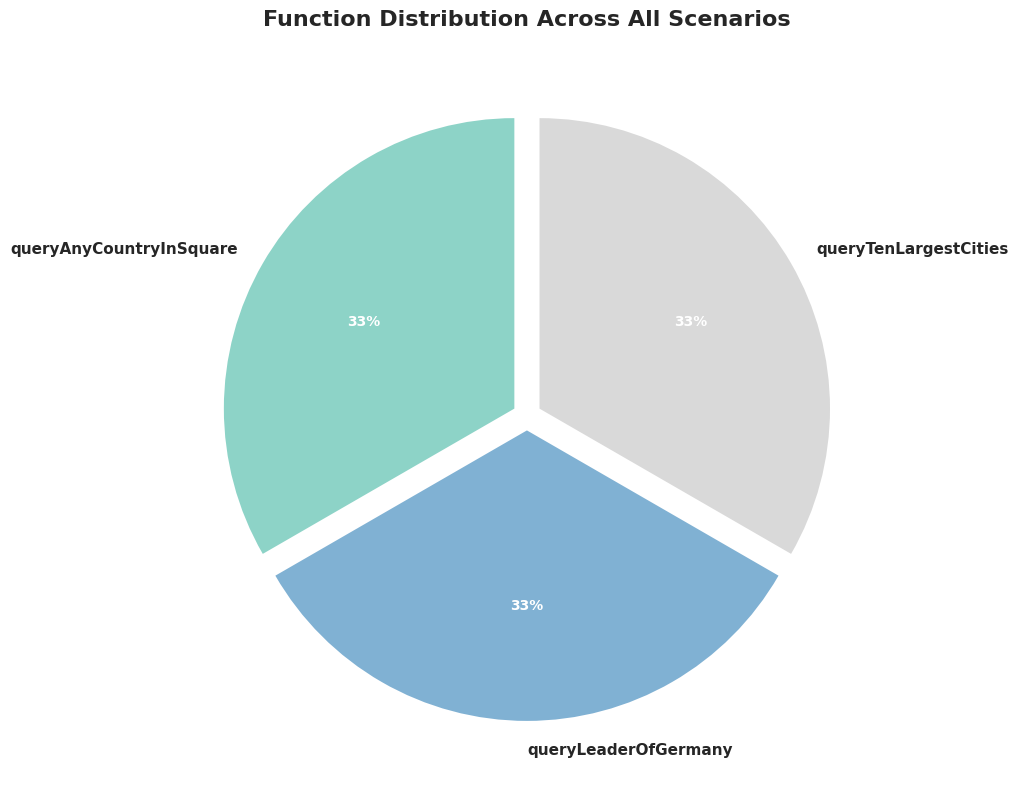

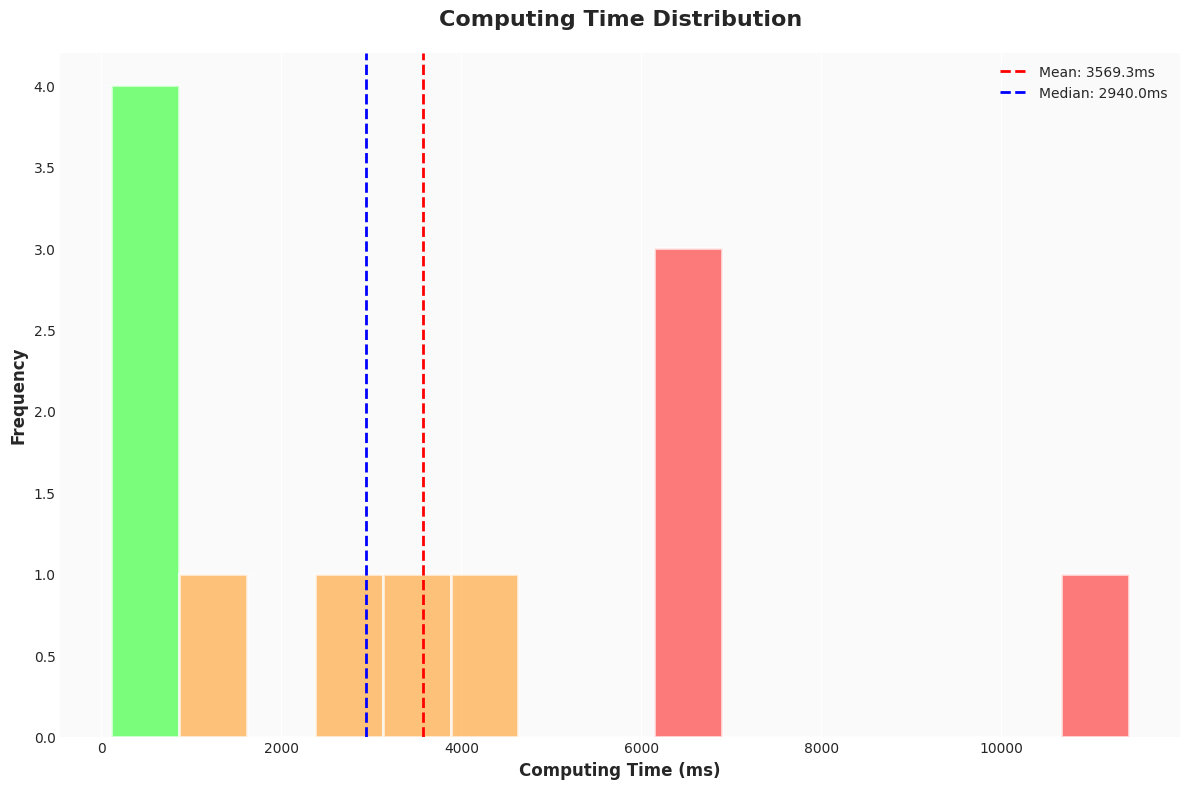

In [27]:
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Set style for better aesthetics
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

with open("resultDictionary.json", "r") as infile:
    resultDictionary = json.load(infile)

    # Prepare data for plotting
    plot_data = []
    for partition, funcs in resultDictionary.items():
        for func_name, metrics in funcs.items():
            key = f"{partition}-{func_name}"
            computing_time = metrics.get("computingTime", None)
            row_count = metrics.get("rowCount", None)
            correctness = metrics.get("correctness", None)
            plot_data.append({
                "key": key,
                "partition": partition,
                "function": func_name,
                "computingTime": computing_time,
                "rowCount": row_count,
                "correctness": correctness
            })

    # Sort by key for consistent plotting
    plot_data = sorted(plot_data, key=lambda x: x["key"])
    keys = [d["key"] for d in plot_data]
    partitions = [d["partition"] for d in plot_data]
    functions = [d["function"] for d in plot_data]
    x = np.arange(len(keys))

    # Extract values for each property
    computing_times = [d["computingTime"] for d in plot_data]
    row_counts = [d["rowCount"] for d in plot_data]
    correctnesses = [d["correctness"] for d in plot_data]

    # Create color mapping for partitions
    unique_partitions = list(set(partitions))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_partitions)))
    partition_colors = {partition: colors[i] for i, partition in enumerate(unique_partitions)}
    point_colors = [partition_colors[p] for p in partitions]
    
    # Create legend patches for all plots
    legend_patches = [mpatches.Patch(color=partition_colors[p], label=p) for p in unique_partitions]

    # Plot 1: Computing Time
    fig1, ax1 = plt.subplots(figsize=(16, 8))
    scatter1 = ax1.scatter(x, computing_times, c=point_colors, s=120, alpha=0.8, 
                          edgecolors='white', linewidth=2)
    ax1.set_xticks(x)
    ax1.set_xticklabels(keys, rotation=45, ha='right', fontsize=10)
    ax1.set_xlabel('Function Scenarios', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Computing Time (ms)', fontsize=12, fontweight='bold')
    ax1.set_title('Computing Time per Function Scenario', fontsize=16, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3)
    ax1.set_facecolor('#fafafa')
    
    # Add value annotations for computing time
    for i, (time, key) in enumerate(zip(computing_times, keys)):
        if time is not None:
            ax1.annotate(f'{time:.0f}ms', (i, time), 
                        textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    
    ax1.legend(handles=legend_patches, loc='upper right', fontsize=10, title='Partitions')
    plt.tight_layout()
    plt.show()

    # Plot 8: Row Count vs Computing Time
    fig8, ax8 = plt.subplots(figsize=(12, 8))
    valid_indices = [i for i, (ct, rc) in enumerate(zip(computing_times, row_counts)) 
                    if ct is not None and rc is not None]
    valid_times = [computing_times[i] for i in valid_indices]
    valid_row_counts = [row_counts[i] for i in valid_indices]
    valid_colors = [point_colors[i] for i in valid_indices]
    valid_keys = [keys[i] for i in valid_indices]
    
    scatter8 = ax8.scatter(valid_row_counts, valid_times, c=valid_colors, s=150, 
                          alpha=0.8, edgecolors='white', linewidth=2)
    ax8.set_xlabel('Row Count', fontsize=12, fontweight='bold')
    ax8.set_ylabel('Computing Time (ms)', fontsize=12, fontweight='bold')
    ax8.set_title('Row Count vs Computing Time Analysis', fontsize=16, fontweight='bold', pad=20)
    ax8.grid(True, alpha=0.3)
    ax8.set_facecolor('#fafafa')
    
    # Format x-axis for row count (scientific notation if needed)
    ax8.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    
    # Add function labels to row count vs computing time plot
    for i, (rc, time, key) in enumerate(zip(valid_row_counts, valid_times, valid_keys)):
        ax8.annotate(key.split('-')[-1], (rc, time), 
                    textcoords="offset points", xytext=(5,5), ha='left', fontsize=8, alpha=0.8)
    
    ax8.legend(handles=legend_patches, loc='upper right', fontsize=10, title='Partitions')
    plt.tight_layout()
    plt.show()

    # Plot 2: Row Count
    fig2, ax2 = plt.subplots(figsize=(16, 8))
    scatter2 = ax2.scatter(x, row_counts, c=point_colors, s=120, alpha=0.8, 
                          edgecolors='white', linewidth=2)
    ax2.set_xticks(x)
    ax2.set_xticklabels(keys, rotation=45, ha='right', fontsize=10)
    ax2.set_xlabel('Function Scenarios', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Row Count', fontsize=12, fontweight='bold')
    ax2.set_title('Row Count per Function Scenario', fontsize=16, fontweight='bold', pad=20)
    ax2.grid(True, alpha=0.3)
    ax2.set_facecolor('#fafafa')
    
    # Format y-axis for row count (scientific notation if needed)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    ax2.legend(handles=legend_patches, loc='upper right', fontsize=10, title='Partitions')
    plt.tight_layout()
    plt.show()

    # Plot 3: Correctness
    fig3, ax3 = plt.subplots(figsize=(16, 8))
    # Use different colors for correctness (red for False, green for True)
    correctness_colors = ['#ff4444' if c is False else '#44ff44' if c is True else '#888888' 
                         for c in correctnesses]
    scatter3 = ax3.scatter(x, correctnesses, c=correctness_colors, s=120, alpha=0.8, 
                          edgecolors='white', linewidth=2)
    ax3.set_xticks(x)
    ax3.set_xticklabels(keys, rotation=45, ha='right', fontsize=10)
    ax3.set_xlabel('Function Scenarios', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Correctness', fontsize=12, fontweight='bold')
    ax3.set_title('Correctness per Function Scenario', fontsize=16, fontweight='bold', pad=20)
    ax3.set_ylim(-0.1, 1.1)
    ax3.set_yticks([0, 1])
    ax3.set_yticklabels(['False', 'True'])
    ax3.grid(True, alpha=0.3)
    ax3.set_facecolor('#fafafa')
    
    # Create custom legend for correctness
    correct_patch = mpatches.Patch(color='#44ff44', label='Correct')
    incorrect_patch = mpatches.Patch(color='#ff4444', label='Incorrect')
    unknown_patch = mpatches.Patch(color='#888888', label='Unknown')
    ax3.legend(handles=[correct_patch, incorrect_patch, unknown_patch], 
              loc='upper right', fontsize=10, title='Correctness')
    
    plt.tight_layout()
    plt.show()

    # Plot 4: Performance vs Correctness Scatter
    fig4, ax4 = plt.subplots(figsize=(12, 8))
    valid_indices = [i for i, (ct, corr) in enumerate(zip(computing_times, correctnesses)) 
                    if ct is not None and corr is not None]
    valid_times = [computing_times[i] for i in valid_indices]
    valid_correctness = [correctnesses[i] for i in valid_indices]
    valid_colors = [point_colors[i] for i in valid_indices]
    valid_keys = [keys[i] for i in valid_indices]
    
    scatter4 = ax4.scatter(valid_times, valid_correctness, c=valid_colors, s=150, 
                          alpha=0.8, edgecolors='white', linewidth=2)
    ax4.set_xlabel('Computing Time (ms)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Correctness', fontsize=12, fontweight='bold')
    ax4.set_title('Performance vs Correctness Analysis', fontsize=16, fontweight='bold', pad=20)
    ax4.set_ylim(-0.1, 1.1)
    ax4.set_yticks([0, 1])
    ax4.set_yticklabels(['False', 'True'])
    ax4.grid(True, alpha=0.3)
    ax4.set_facecolor('#fafafa')
    
    # Add function labels to performance vs correctness plot
    for i, (time, corr, key) in enumerate(zip(valid_times, valid_correctness, valid_keys)):
        ax4.annotate(key.split('-')[-1], (time, corr), 
                    textcoords="offset points", xytext=(5,5), ha='left', fontsize=8, alpha=0.8)
    
    ax4.legend(handles=legend_patches, loc='upper right', fontsize=10, title='Partitions')
    plt.tight_layout()
    plt.show()

    # Plot 5: Average Computing Time by Partition (Bar Chart)
    fig5, ax5 = plt.subplots(figsize=(12, 8))
    partition_data = {}
    for partition, func, time in zip(partitions, functions, computing_times):
        if time is not None:
            if partition not in partition_data:
                partition_data[partition] = []
            partition_data[partition].append(time)
    
    partition_names = list(partition_data.keys())
    partition_avg_times = [np.mean(times) for times in partition_data.values()]
    partition_bar_colors = [partition_colors[p] for p in partition_names]
    
    bars = ax5.bar(partition_names, partition_avg_times, color=partition_bar_colors, 
                   alpha=0.8, edgecolor='white', linewidth=2)
    ax5.set_xlabel('Partitions', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Average Computing Time (ms)', fontsize=12, fontweight='bold')
    ax5.set_title('Average Computing Time by Partition', fontsize=16, fontweight='bold', pad=20)
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True, alpha=0.3, axis='y')
    ax5.set_facecolor('#fafafa')
    
    # Add value labels on bars
    for bar, value in zip(bars, partition_avg_times):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.1f}ms', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    # Plot 6: Function Distribution (Pie Chart)
    fig6, ax6 = plt.subplots(figsize=(10, 8))
    function_counts = {}
    for func in functions:
        func_name = func.split('-')[-1]
        function_counts[func_name] = function_counts.get(func_name, 0) + 1
    
    wedges, texts, autotexts = ax6.pie(function_counts.values(), labels=function_counts.keys(),
                                      autopct='%1.0f%%', startangle=90, 
                                      colors=colors[:len(function_counts)],
                                      explode=[0.05]*len(function_counts))
    ax6.set_title('Function Distribution Across All Scenarios', fontsize=16, fontweight='bold', pad=20)
    
    # Enhance pie chart text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    for text in texts:
        text.set_fontsize(11)
        text.set_fontweight('bold')
    
    plt.tight_layout()
    plt.show()

    # Plot 7: Computing Time Distribution (Histogram)
    fig7, ax7 = plt.subplots(figsize=(12, 8))
    valid_computing_times = [t for t in computing_times if t is not None]
    
    n, bins, patches = ax7.hist(valid_computing_times, bins=15, alpha=0.7, 
                               color='skyblue', edgecolor='white', linewidth=2)
    
    # Color bars based on value ranges
    for i, patch in enumerate(patches):
        if bins[i] < np.percentile(valid_computing_times, 33):
            patch.set_facecolor('#44ff44')  # Green for fast
        elif bins[i] < np.percentile(valid_computing_times, 67):
            patch.set_facecolor('#ffaa44')  # Orange for medium
        else:
            patch.set_facecolor('#ff4444')  # Red for slow
    
    ax7.set_xlabel('Computing Time (ms)', fontsize=12, fontweight='bold')
    ax7.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax7.set_title('Computing Time Distribution', fontsize=16, fontweight='bold', pad=20)
    ax7.grid(True, alpha=0.3, axis='y')
    ax7.set_facecolor('#fafafa')
    
    # Add statistics
    mean_time = np.mean(valid_computing_times)
    median_time = np.median(valid_computing_times)
    ax7.axvline(mean_time, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_time:.1f}ms')
    ax7.axvline(median_time, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_time:.1f}ms')
    ax7.legend()
    
    plt.tight_layout()
    plt.show()